[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danpele/Time-Series-Analysis/blob/main/EN/Course_Notebooks/chapter0_lecture_notebook.ipynb)

---

# Chapter 0: Fundamentals of Time Series Analysis

**Course:** Time Series Analysis and Forecasting  
**Program:** Bachelor program, Faculty of Cybernetics, Statistics and Economic Informatics, Bucharest University of Economic Studies, Romania  
**Academic Year:** 2025-2026

---

## Learning Objectives

By the end of this notebook, you will be able to:
1. Define time series and distinguish from cross-sectional and panel data
2. Decompose time series into trend-cycle, seasonal, and residual components
3. Apply exponential smoothing methods (SES, Holt, Holt-Winters, ETS)
4. Evaluate forecasts using MAE, RMSE, MAPE, sMAPE
5. Implement train/validation/test splits and cross-validation
6. Model seasonality using dummy variables or Fourier terms
7. Remove trend and seasonality through appropriate methods
8. Distinguish between deterministic and stochastic trends

## Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Time series specific
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.filters.hp_filter import hpfilter
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

# Plotting style - clean, professional
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.facecolor'] = 'none'  # Transparent background
plt.rcParams['figure.facecolor'] = 'none'  # Transparent figure
plt.rcParams['savefig.facecolor'] = 'none'
plt.rcParams['savefig.transparent'] = True
plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.grid'] = False  # No grid
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Colors (IDA color scheme)
COLORS = {
    'blue': '#1A3A6E',
    'red': '#DC3545',
    'green': '#2E7D32',
    'orange': '#E67E22',
    'purple': '#8E44AD',
    'gray': '#666666'
}

print("All libraries loaded successfully!")

All libraries loaded successfully!


## 1. What is a Time Series?

A **time series** is a sequence of observations indexed by time:

$$\{X_t : t \in \mathbf{T}\}$$

### Key Characteristics:
- **Ordered**: Observations have a natural temporal ordering
- **Dependent**: Consecutive observations are typically correlated
- **Discrete or Continuous**: Time index can be discrete or continuous

In [2]:
# Download real financial data
print("Downloading S&P 500 data...")
sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-01-01', progress=False)
# Flatten multi-level columns (newer yfinance returns MultiIndex)
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = sp500.columns.droplevel(1)
print(f"Downloaded {len(sp500)} observations")

# Display first few rows
sp500.head()

Downloaded 1258 observations


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000


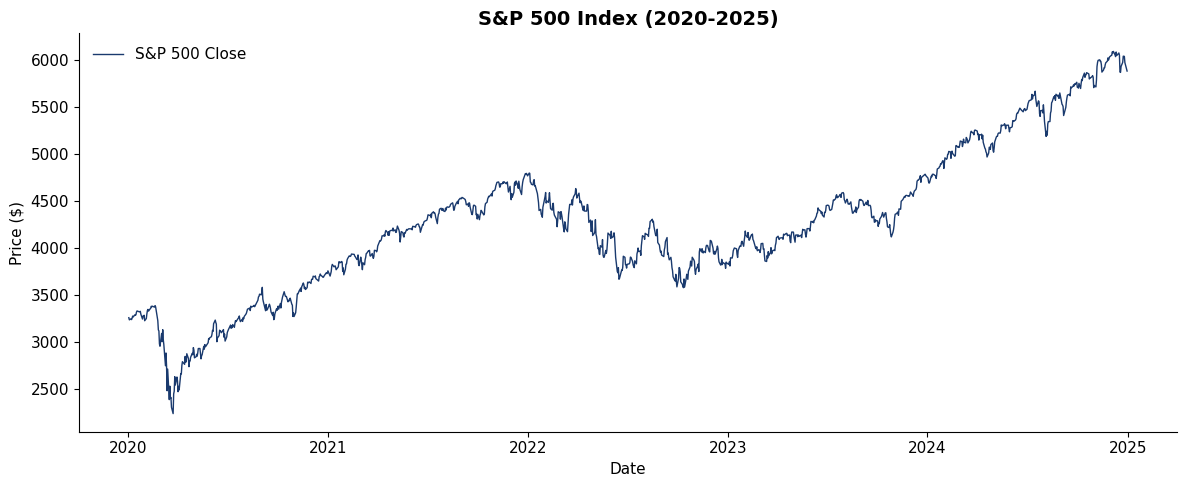


Basic Statistics:
Mean: $4259.61
Std Dev: $767.45
Min: $2237.40
Max: $6090.27


In [3]:
# Plot the time series
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(sp500.index, sp500['Close'], color=COLORS['blue'], linewidth=1, label='S&P 500 Close')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('S&P 500 Index (2020-2025)', fontweight='bold', fontsize=14)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

print(f"\nBasic Statistics:")
print(f"Mean: ${sp500['Close'].mean():.2f}")
print(f"Std Dev: ${sp500['Close'].std():.2f}")
print(f"Min: ${sp500['Close'].min():.2f}")
print(f"Max: ${sp500['Close'].max():.2f}")

### Types of Data: Comparison

| Data Type | Units (N) | Time (T) | Example |
|-----------|-----------|----------|----------|
| Cross-sectional | Many | 1 | Survey of 1000 households |
| Time series | 1 | Many | Daily S&P 500 prices |
| Panel | Many | Many | GDP of 50 countries, 20 years |

## 2. Time Series Decomposition

### Decomposition Models

**Additive Model:** $X_t = T_t + S_t + \varepsilon_t$
- Use when seasonal fluctuations are **constant** over time

**Multiplicative Model:** $X_t = T_t \times S_t \times \varepsilon_t$
- Use when seasonal fluctuations **grow** with the level

**Components:**
- $T_t$ = **Trend-Cycle**: Long-term movement
- $S_t$ = **Seasonal**: Regular periodic pattern
- $\varepsilon_t$ = **Residual**: Random noise

In [4]:
# Load airline passengers data (classic example with trend and seasonality)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
airline = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
airline.columns = ['Passengers']

print(f"Airline Passengers Data: {len(airline)} observations")
print(f"Period: {airline.index[0].strftime('%Y-%m')} to {airline.index[-1].strftime('%Y-%m')}")
airline.head()

Airline Passengers Data: 144 observations
Period: 1949-01 to 1960-12


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


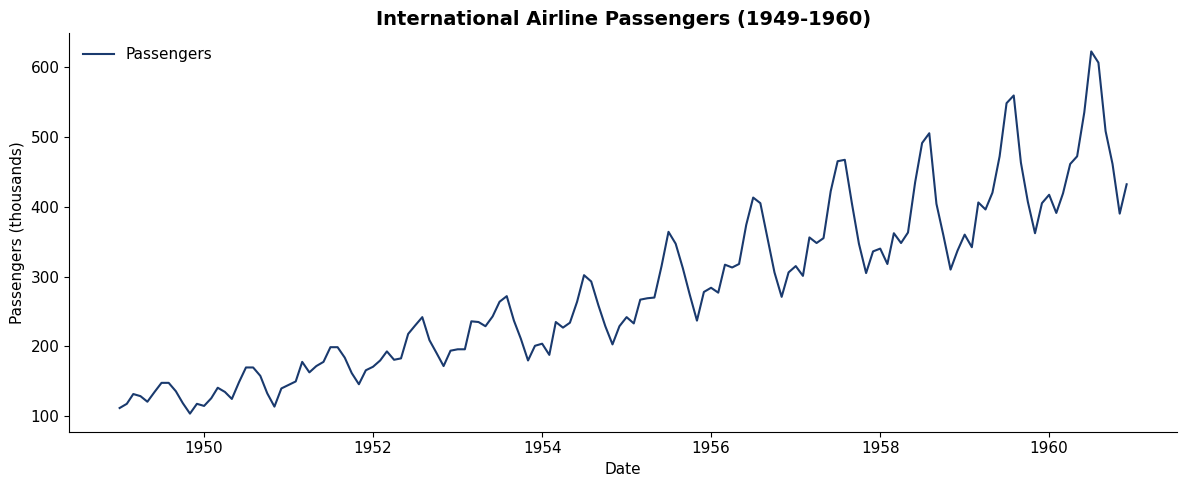


Observations:
- Clear upward TREND
- Regular SEASONAL pattern (peaks in summer)
- Seasonal amplitude INCREASES with level -> Multiplicative!


In [5]:
# Plot airline data
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(airline.index, airline['Passengers'], color=COLORS['blue'], linewidth=1.5, label='Passengers')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers (thousands)')
ax.set_title('International Airline Passengers (1949-1960)', fontweight='bold', fontsize=14)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Clear upward TREND")
print("- Regular SEASONAL pattern (peaks in summer)")
print("- Seasonal amplitude INCREASES with level -> Multiplicative!")

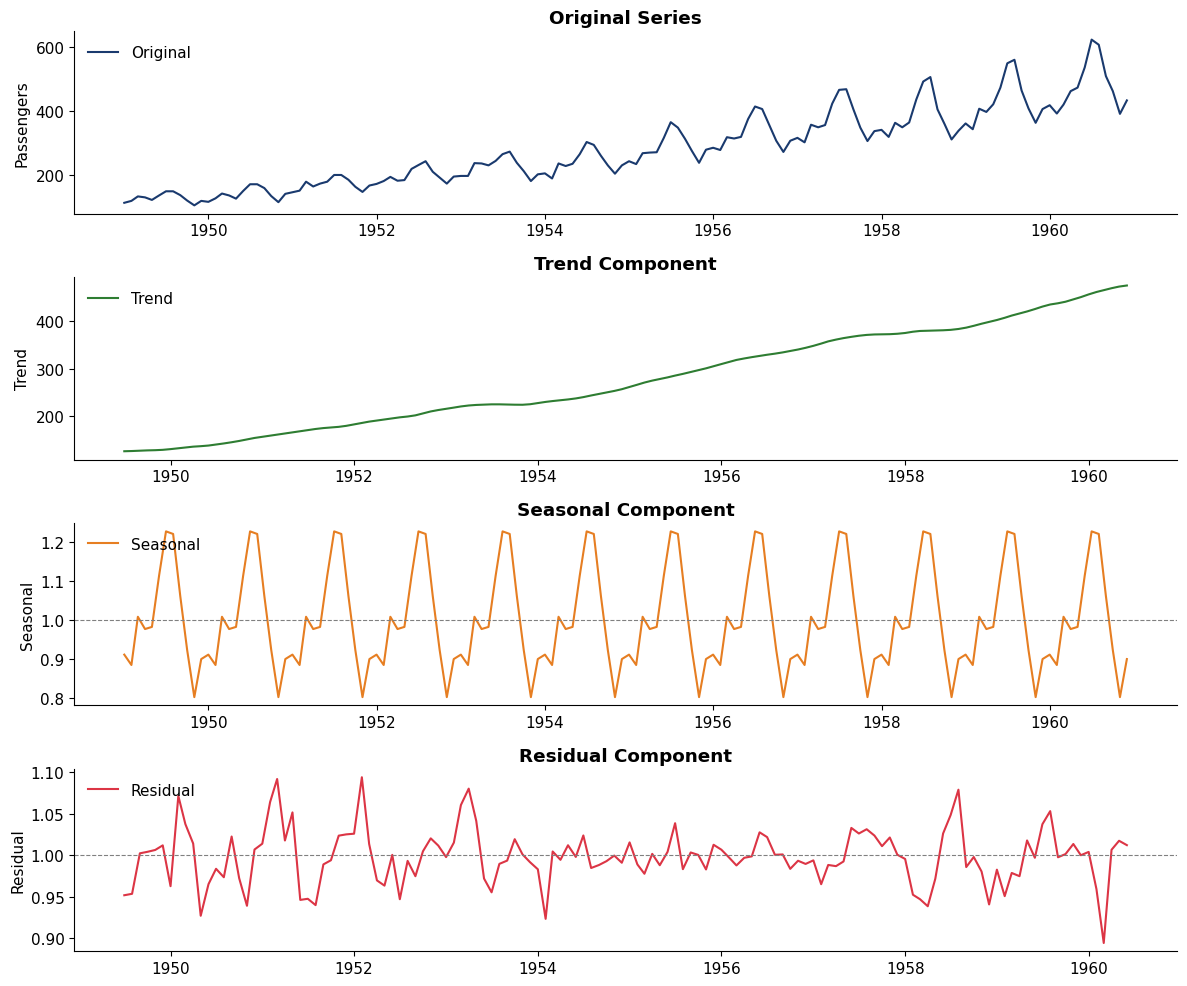

Multiplicative Decomposition: X = Trend * Seasonal * Residual


In [6]:
# Classical Decomposition - Multiplicative
decomposition = seasonal_decompose(airline['Passengers'], model='multiplicative', period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 10))

axes[0].plot(airline.index, airline['Passengers'], color=COLORS['blue'], label='Original')
axes[0].set_title('Original Series', fontweight='bold')
axes[0].set_ylabel('Passengers')
axes[0].legend(loc='upper left')

axes[1].plot(airline.index, decomposition.trend, color=COLORS['green'], label='Trend')
axes[1].set_title('Trend Component', fontweight='bold')
axes[1].set_ylabel('Trend')
axes[1].legend(loc='upper left')

axes[2].plot(airline.index, decomposition.seasonal, color=COLORS['orange'], label='Seasonal')
axes[2].set_title('Seasonal Component', fontweight='bold')
axes[2].set_ylabel('Seasonal')
axes[2].axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
axes[2].legend(loc='upper left')

axes[3].plot(airline.index, decomposition.resid, color=COLORS['red'], label='Residual')
axes[3].set_title('Residual Component', fontweight='bold')
axes[3].set_ylabel('Residual')
axes[3].axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

print("Multiplicative Decomposition: X = Trend * Seasonal * Residual")

### Additive vs Multiplicative: Visualization

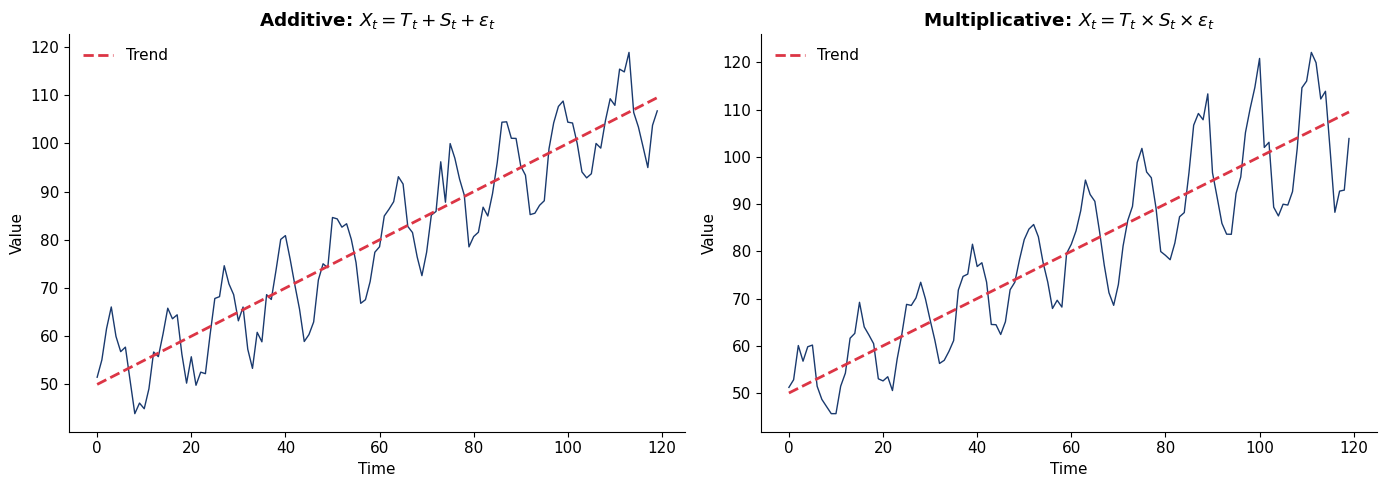

Key Difference:
- Additive: Seasonal amplitude stays CONSTANT
- Multiplicative: Seasonal amplitude GROWS with level


In [7]:
# Compare additive vs multiplicative decomposition
np.random.seed(42)
n = 120
t = np.arange(n)
trend = 50 + 0.5 * t
seasonal = 10 * np.sin(2 * np.pi * t / 12)

# Additive: constant seasonal amplitude
additive = trend + seasonal + np.random.randn(n) * 3

# Multiplicative: seasonal amplitude grows with level
multiplicative = trend * (1 + 0.15 * np.sin(2 * np.pi * t / 12)) * (1 + np.random.randn(n) * 0.03)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(additive, color=COLORS['blue'], linewidth=1)
axes[0].plot(trend, color=COLORS['red'], linewidth=2, linestyle='--', label='Trend')
axes[0].set_title('Additive: $X_t = T_t + S_t + \\varepsilon_t$', fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].legend(loc='upper left')

axes[1].plot(multiplicative, color=COLORS['blue'], linewidth=1)
axes[1].plot(trend, color=COLORS['red'], linewidth=2, linestyle='--', label='Trend')
axes[1].set_title('Multiplicative: $X_t = T_t \\times S_t \\times \\varepsilon_t$', fontweight='bold')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Value')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

print("Key Difference:")
print("- Additive: Seasonal amplitude stays CONSTANT")
print("- Multiplicative: Seasonal amplitude GROWS with level")

### Seasonal Indices Interpretation

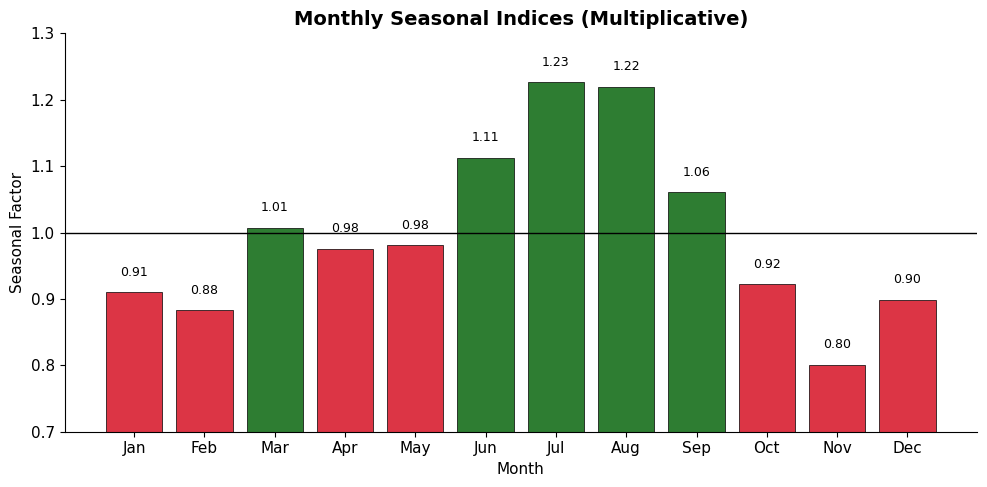


Interpretation:
- July factor = 1.23 -> 23% above average
- November factor = 0.80 -> 20% below average


In [8]:
# Extract monthly seasonal factors
seasonal_factors = decomposition.seasonal[:12]

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(10, 5))
colors = [COLORS['red'] if s < 1 else COLORS['green'] for s in seasonal_factors]
bars = ax.bar(months, seasonal_factors, color=colors, edgecolor='black', linewidth=0.5)
ax.axhline(y=1, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Month')
ax.set_ylabel('Seasonal Factor')
ax.set_title('Monthly Seasonal Indices (Multiplicative)', fontweight='bold', fontsize=14)
ax.set_ylim(0.7, 1.3)

# Add value labels
for bar, val in zip(bars, seasonal_factors):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print(f"- July factor = {seasonal_factors.iloc[6]:.2f} -> {(seasonal_factors.iloc[6]-1)*100:.0f}% above average")
print(f"- November factor = {seasonal_factors.iloc[10]:.2f} -> {(1-seasonal_factors.iloc[10])*100:.0f}% below average")

### STL Decomposition (Modern Approach)

**STL** = Seasonal-Trend decomposition using LOESS (locally weighted regression)

**Advantages:**
- Handles any seasonal period
- Seasonal component can change over time
- Robust to outliers

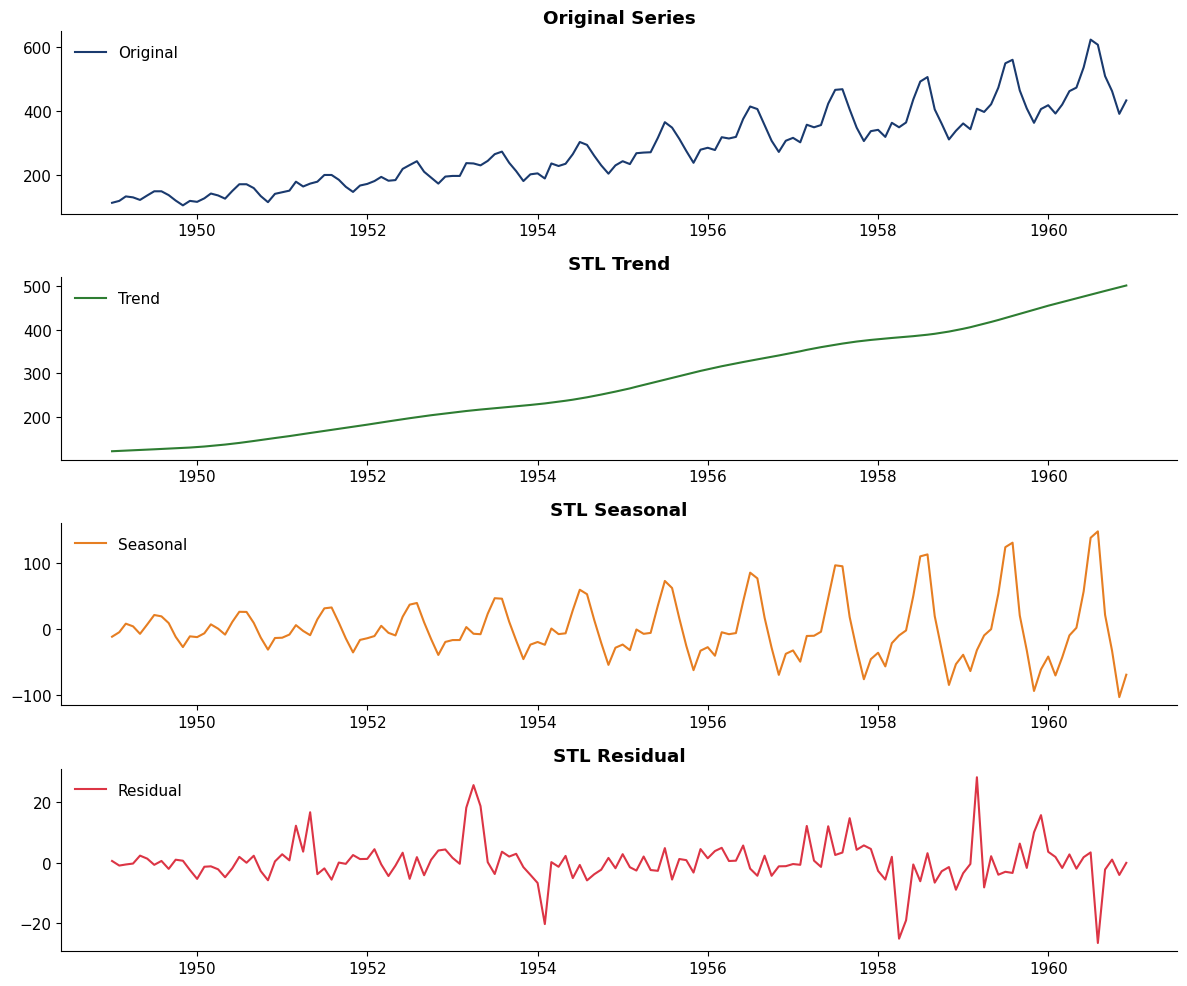

STL Decomposition is ADDITIVE: X = Trend + Seasonal + Residual


In [9]:
# STL Decomposition (additive, more robust)
stl = STL(airline['Passengers'], period=12, robust=True)
stl_result = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(12, 10))

axes[0].plot(airline.index, airline['Passengers'], color=COLORS['blue'], label='Original')
axes[0].set_title('Original Series', fontweight='bold')
axes[0].legend(loc='upper left')

axes[1].plot(airline.index, stl_result.trend, color=COLORS['green'], label='Trend')
axes[1].set_title('STL Trend', fontweight='bold')
axes[1].legend(loc='upper left')

axes[2].plot(airline.index, stl_result.seasonal, color=COLORS['orange'], label='Seasonal')
axes[2].set_title('STL Seasonal', fontweight='bold')
axes[2].legend(loc='upper left')

axes[3].plot(airline.index, stl_result.resid, color=COLORS['red'], label='Residual')
axes[3].set_title('STL Residual', fontweight='bold')
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

print("STL Decomposition is ADDITIVE: X = Trend + Seasonal + Residual")

## 3. Trend Estimation Methods

### Moving Average Smoothing

**Centered Moving Average** of order $2q+1$:
$$\hat{T}_t = \frac{1}{2q+1} \sum_{j=-q}^{q} X_{t+j}$$

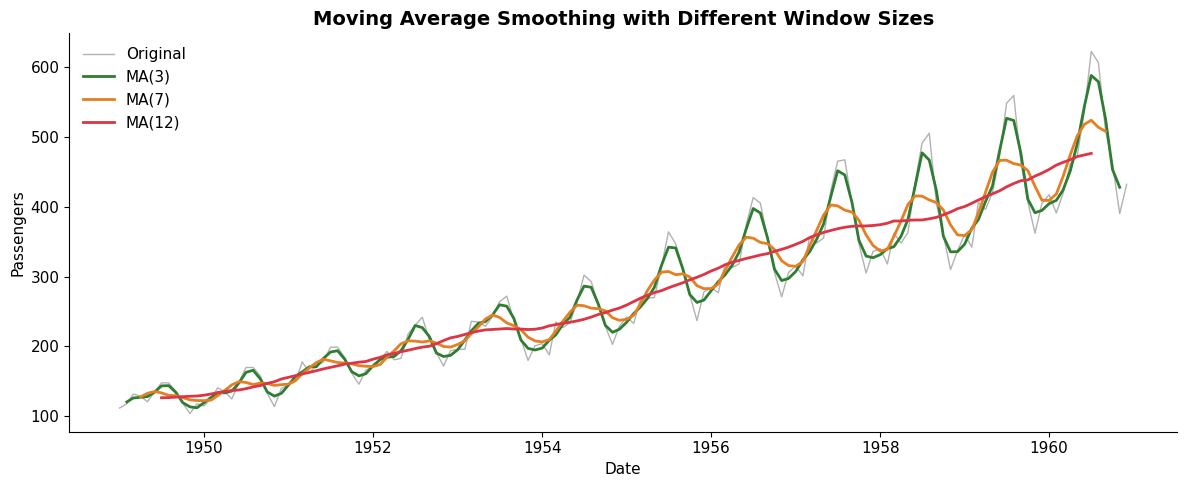

Window Size Trade-off:
- Small window: Responsive but noisy
- Large window: Smoother but slower to react


In [10]:
# Moving Average with different window sizes
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(airline.index, airline['Passengers'], color=COLORS['gray'], alpha=0.5, linewidth=1, label='Original')

for window, color in zip([3, 7, 12], [COLORS['green'], COLORS['orange'], COLORS['red']]):
    ma = airline['Passengers'].rolling(window=window, center=True).mean()
    ax.plot(airline.index, ma, color=color, linewidth=2, label=f'MA({window})')

ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.set_title('Moving Average Smoothing with Different Window Sizes', fontweight='bold', fontsize=14)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

print("Window Size Trade-off:")
print("- Small window: Responsive but noisy")
print("- Large window: Smoother but slower to react")

### Hodrick-Prescott (HP) Filter

The HP filter minimizes:
$$\min_{\{\tau_t\}} \left\{ \sum_{t=1}^{T}(X_t - \tau_t)^2 + \lambda \sum_{t=2}^{T-1}[(\tau_{t+1} - \tau_t) - (\tau_t - \tau_{t-1})]^2 \right\}$$

**Standard $\lambda$ values:**
- Annual: $\lambda = 6.25$
- Quarterly: $\lambda = 1600$
- Monthly: $\lambda = 129600$

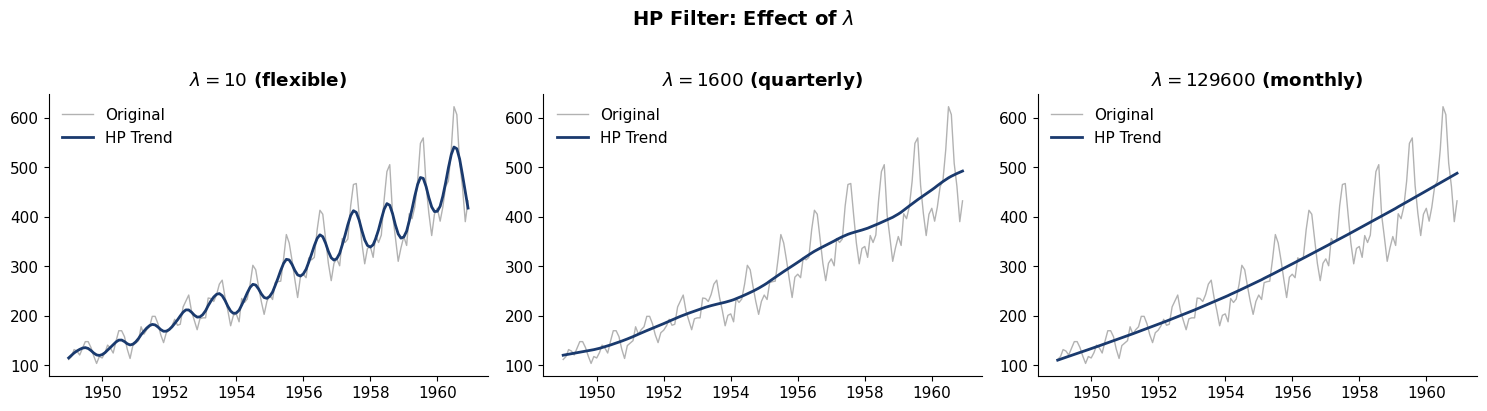

Trade-off:
- Small lambda: Trend follows data closely
- Large lambda: Trend becomes smoother (approaches linear)


In [11]:
# HP Filter with different lambda values
lambdas = [10, 1600, 129600]
labels = ['$\\lambda=10$ (flexible)', '$\\lambda=1600$ (quarterly)', '$\\lambda=129600$ (monthly)']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (lam, label) in enumerate(zip(lambdas, labels)):
    cycle, trend = hpfilter(airline['Passengers'], lamb=lam)

    axes[i].plot(airline.index, airline['Passengers'], color=COLORS['gray'], alpha=0.5, linewidth=1, label='Original')
    axes[i].plot(airline.index, trend, color=COLORS['blue'], linewidth=2, label='HP Trend')
    axes[i].set_title(label, fontweight='bold')
    axes[i].legend(loc='upper left')

plt.suptitle('HP Filter: Effect of $\\lambda$', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Trade-off:")
print("- Small lambda: Trend follows data closely")
print("- Large lambda: Trend becomes smoother (approaches linear)")

## 4. Exponential Smoothing Methods

### Simple Exponential Smoothing (SES)

$$\hat{X}_{t+1|t} = \alpha X_t + (1-\alpha)\hat{X}_{t|t-1}$$

where $\alpha \in (0,1)$ is the smoothing parameter.

- **Large $\alpha$**: Responsive to recent changes
- **Small $\alpha$**: Smoother, more stable forecasts

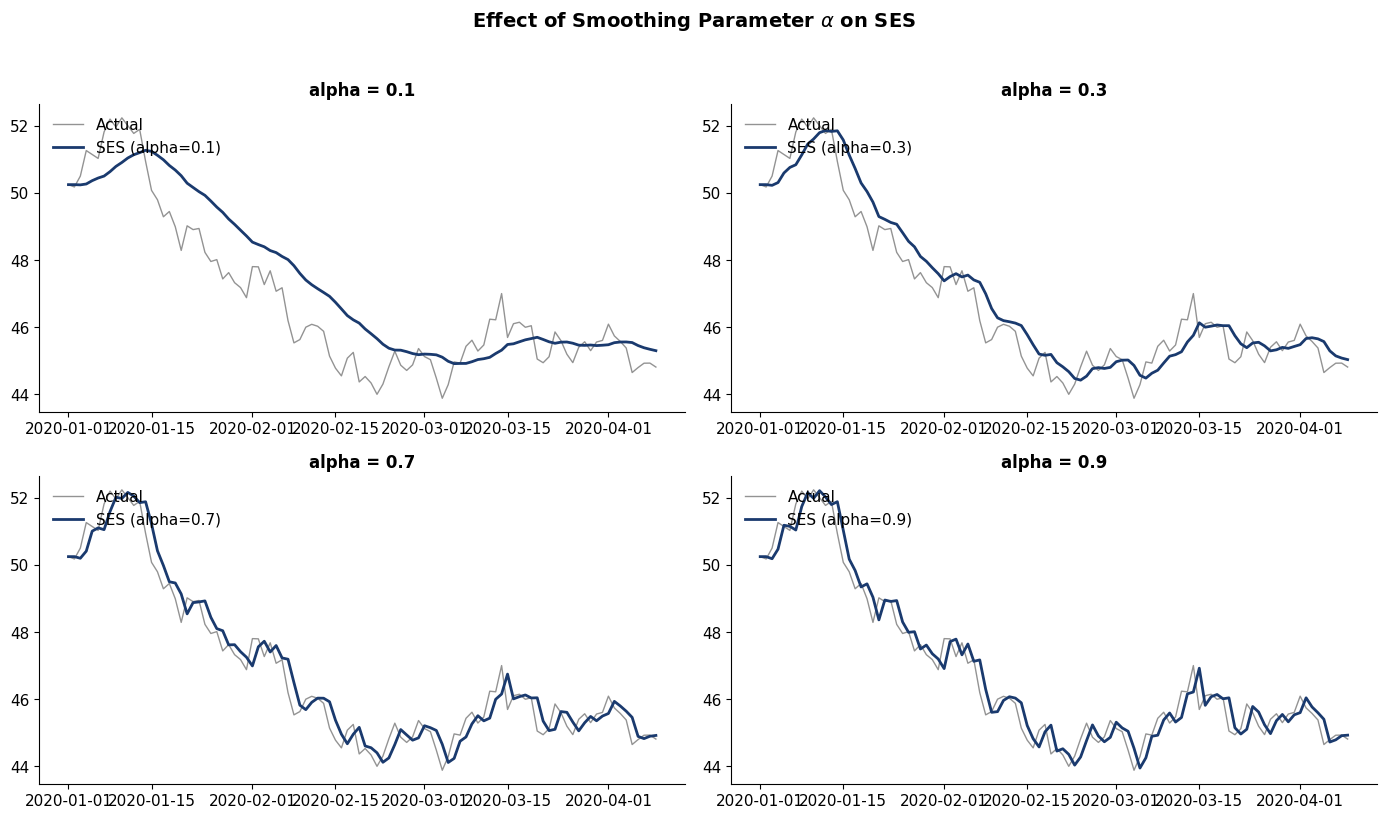

Observation: Higher alpha -> more reactive to changes, Lower alpha -> smoother


In [12]:
# Create synthetic data without trend/seasonality for SES demo
np.random.seed(42)
n = 100
synthetic = pd.Series(50 + np.cumsum(np.random.randn(n) * 0.5),
                      index=pd.date_range('2020-01-01', periods=n, freq='D'))

# Fit SES with different alpha values
alphas = [0.1, 0.3, 0.7, 0.9]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, alpha in enumerate(alphas):
    model = SimpleExpSmoothing(synthetic).fit(smoothing_level=alpha, optimized=False)
    fitted = model.fittedvalues

    axes[i].plot(synthetic.index, synthetic, color=COLORS['gray'],
                 linewidth=1, alpha=0.7, label='Actual')
    axes[i].plot(fitted.index, fitted, color=COLORS['blue'],
                 linewidth=2, label=f'SES (alpha={alpha})')
    axes[i].set_title(f'alpha = {alpha}', fontweight='bold', fontsize=12)
    axes[i].legend(loc='upper left')

plt.suptitle('Effect of Smoothing Parameter $\\alpha$ on SES', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Observation: Higher alpha -> more reactive to changes, Lower alpha -> smoother")

### Holt's Linear Trend Method

**Level:** $\ell_t = \alpha X_t + (1-\alpha)(\ell_{t-1} + b_{t-1})$

**Trend:** $b_t = \beta^*(\ell_t - \ell_{t-1}) + (1-\beta^*)b_{t-1}$

**Forecast:** $\hat{X}_{t+h|t} = \ell_t + h \cdot b_t$

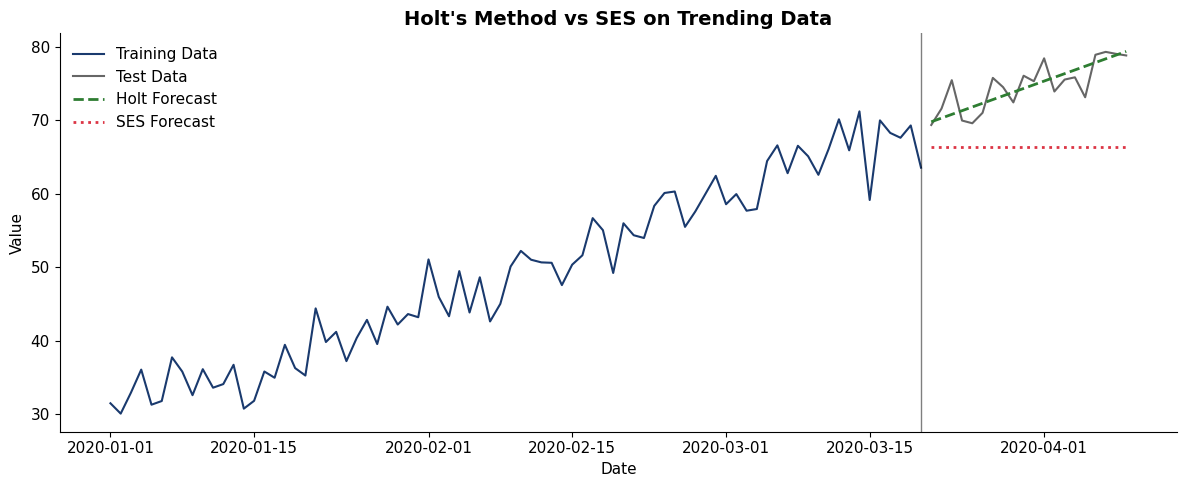


Holt RMSE: 2.03
SES RMSE: 8.92

Holt captures the trend, SES does not!


In [13]:
# Create data with trend
np.random.seed(42)
n = 100
trend_data = pd.Series(30 + 0.5 * np.arange(n) + np.random.randn(n) * 3,
                       index=pd.date_range('2020-01-01', periods=n, freq='D'))

# Split into train/test
train_size = 80
train = trend_data[:train_size]
test = trend_data[train_size:]

# Fit Holt's method
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(len(test))

# Also fit SES for comparison
ses_model = SimpleExpSmoothing(train).fit()
ses_forecast = ses_model.forecast(len(test))

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(train.index, train, color=COLORS['blue'], linewidth=1.5, label='Training Data')
ax.plot(test.index, test, color=COLORS['gray'], linewidth=1.5, label='Test Data')
ax.plot(test.index, holt_forecast, color=COLORS['green'], linewidth=2,
        linestyle='--', label='Holt Forecast')
ax.plot(test.index, ses_forecast, color=COLORS['red'], linewidth=2,
        linestyle=':', label='SES Forecast')
ax.axvline(x=train.index[-1], color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title("Holt's Method vs SES on Trending Data", fontweight='bold', fontsize=14)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Calculate errors
holt_rmse = np.sqrt(mean_squared_error(test, holt_forecast))
ses_rmse = np.sqrt(mean_squared_error(test, ses_forecast))
print(f"\nHolt RMSE: {holt_rmse:.2f}")
print(f"SES RMSE: {ses_rmse:.2f}")
print(f"\nHolt captures the trend, SES does not!")

### Holt-Winters Seasonal Method

Extends Holt's method to include **seasonality**:

- **Level:** $\ell_t = \alpha(X_t - S_{t-s}) + (1-\alpha)(\ell_{t-1} + b_{t-1})$
- **Trend:** $b_t = \beta^*(\ell_t - \ell_{t-1}) + (1-\beta^*)b_{t-1}$  
- **Seasonal:** $S_t = \gamma(X_t - \ell_t) + (1-\gamma)S_{t-s}$
- **Forecast:** $\hat{X}_{t+h|t} = \ell_t + h \cdot b_t + S_{t+h-s(k+1)}$

In [14]:
# Use airline data with train/test split
train_airline = airline[:'1958']
test_airline = airline['1959':]

print(f"Training: {len(train_airline)} observations ({train_airline.index[0].strftime('%Y-%m')} to {train_airline.index[-1].strftime('%Y-%m')})")
print(f"Testing: {len(test_airline)} observations ({test_airline.index[0].strftime('%Y-%m')} to {test_airline.index[-1].strftime('%Y-%m')})")

Training: 120 observations (1949-01 to 1958-12)
Testing: 24 observations (1959-01 to 1960-12)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


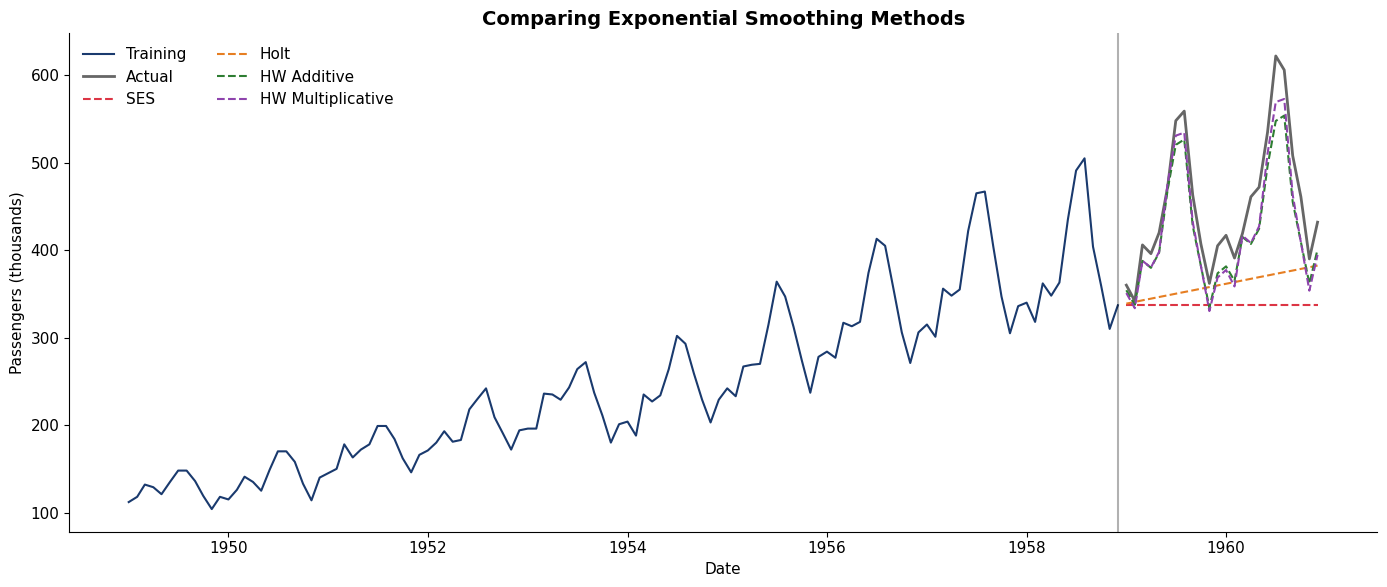

In [15]:
# Fit different methods
ses = SimpleExpSmoothing(train_airline['Passengers']).fit()
holt = ExponentialSmoothing(train_airline['Passengers'], trend='add', seasonal=None).fit()
hw_add = ExponentialSmoothing(train_airline['Passengers'], trend='add',
                               seasonal='add', seasonal_periods=12).fit()
hw_mul = ExponentialSmoothing(train_airline['Passengers'], trend='add',
                               seasonal='mul', seasonal_periods=12).fit()

# Generate forecasts
h = len(test_airline)
forecasts = {
    'SES': ses.forecast(h),
    'Holt': holt.forecast(h),
    'HW Additive': hw_add.forecast(h),
    'HW Multiplicative': hw_mul.forecast(h)
}

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train_airline.index, train_airline['Passengers'], color=COLORS['blue'],
        linewidth=1.5, label='Training')
ax.plot(test_airline.index, test_airline['Passengers'], color=COLORS['gray'],
        linewidth=2, label='Actual')

colors_list = [COLORS['red'], COLORS['orange'], COLORS['green'], COLORS['purple']]
for (name, fc), color in zip(forecasts.items(), colors_list):
    ax.plot(test_airline.index, fc, linewidth=1.5, linestyle='--',
            color=color, label=name)

ax.axvline(x=train_airline.index[-1], color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers (thousands)')
ax.set_title('Comparing Exponential Smoothing Methods', fontweight='bold', fontsize=14)
ax.legend(loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

In [16]:
# Calculate error metrics
def mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

print("Forecast Accuracy Comparison:")
print("=" * 50)
print(f"{'Method':<20} {'RMSE':>10} {'MAE':>10} {'MAPE':>10}")
print("-" * 50)

actual = test_airline['Passengers'].values
for name, fc in forecasts.items():
    rmse = np.sqrt(mean_squared_error(actual, fc))
    mae = mean_absolute_error(actual, fc)
    mape_val = mape(actual, fc)
    print(f"{name:<20} {rmse:>10.2f} {mae:>10.2f} {mape_val:>9.2f}%")

print("\nConclusion: Holt-Winters Multiplicative performs best for seasonal data!")

Forecast Accuracy Comparison:
Method                     RMSE        MAE       MAPE
--------------------------------------------------
SES                      137.33     115.25     23.58%
Holt                     115.70      91.62     18.41%
HW Additive               35.76      31.08      6.64%
HW Multiplicative         32.49      28.98      6.39%

Conclusion: Holt-Winters Multiplicative performs best for seasonal data!


### ETS Framework: Error-Trend-Seasonal

The **ETS framework** generalizes exponential smoothing: ETS$(E, T, S)$

| Component | N | A | M |
|-----------|---|---|---|
| Error (E) | -- | Additive | Multiplicative |
| Trend (T) | None | Additive | Multiplicative |
| Seasonal (S) | None | Additive | Multiplicative |

**Examples:**
- ETS(A,N,N) = Simple Exponential Smoothing
- ETS(A,A,N) = Holt's Linear Method
- ETS(A,A,A) = Holt-Winters Additive
- ETS(A,A,M) = Holt-Winters Multiplicative

## 5. Forecast Evaluation

### Error Metrics

**Scale-Dependent:**
- MAE = $\frac{1}{n}\sum|e_t|$
- MSE = $\frac{1}{n}\sum e_t^2$
- RMSE = $\sqrt{\text{MSE}}$

**Scale-Independent:**
- MAPE = $\frac{100}{n}\sum\left|\frac{e_t}{X_t}\right|$
- sMAPE = $\frac{100}{n}\sum\frac{|e_t|}{(|X_t|+|\hat{X}_t|)/2}$

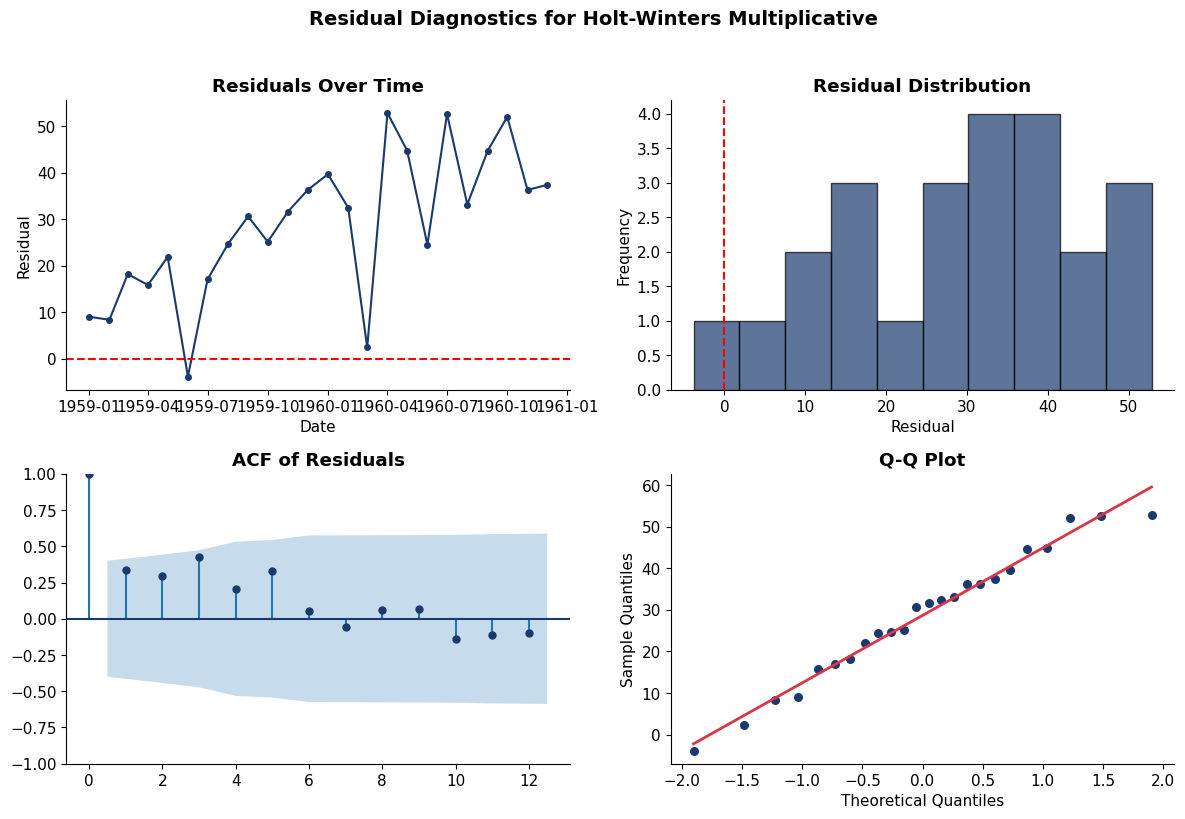

In [17]:
# Residual diagnostics for the best model
residuals = test_airline['Passengers'].values - forecasts['HW Multiplicative'].values

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residuals over time
axes[0, 0].plot(test_airline.index, residuals, color=COLORS['blue'], marker='o', markersize=4)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual')

# Histogram
axes[0, 1].hist(residuals, bins=10, color=COLORS['blue'], edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--')
axes[0, 1].set_title('Residual Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')

# ACF of residuals
plot_acf(residuals, ax=axes[1, 0], lags=12, color=COLORS['blue'])
axes[1, 0].set_title('ACF of Residuals', fontweight='bold')

# Q-Q plot
(osm, osr), (slope, intercept, r) = stats.probplot(residuals, dist="norm")
axes[1, 1].scatter(osm, osr, color=COLORS['blue'], s=30)
axes[1, 1].plot(osm, slope*osm + intercept, color=COLORS['red'], linewidth=2)
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')
axes[1, 1].set_xlabel('Theoretical Quantiles')
axes[1, 1].set_ylabel('Sample Quantiles')

plt.suptitle('Residual Diagnostics for Holt-Winters Multiplicative', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [18]:
# Ljung-Box test
lb_result = acorr_ljungbox(residuals, lags=[6, 12], return_df=True)
print("\nLjung-Box Test for Residual Autocorrelation:")
print(lb_result)
print("\nIf p-values > 0.05, residuals are not significantly autocorrelated (good!)")


Ljung-Box Test for Residual Autocorrelation:
      lb_stat  lb_pvalue
6   15.924989   0.014162
12  18.360056   0.105187

If p-values > 0.05, residuals are not significantly autocorrelated (good!)


### Train / Validation / Test Split

| Set | Purpose | Usage |
|-----|---------|-------|
| **Train** | Fit model parameters | 60-80% of data |
| **Validation** | Tune hyperparameters, compare models | 10-20% |
| **Test** | Final evaluation only | 10-20% |

**Critical Rule:** Never use test set for model selection!

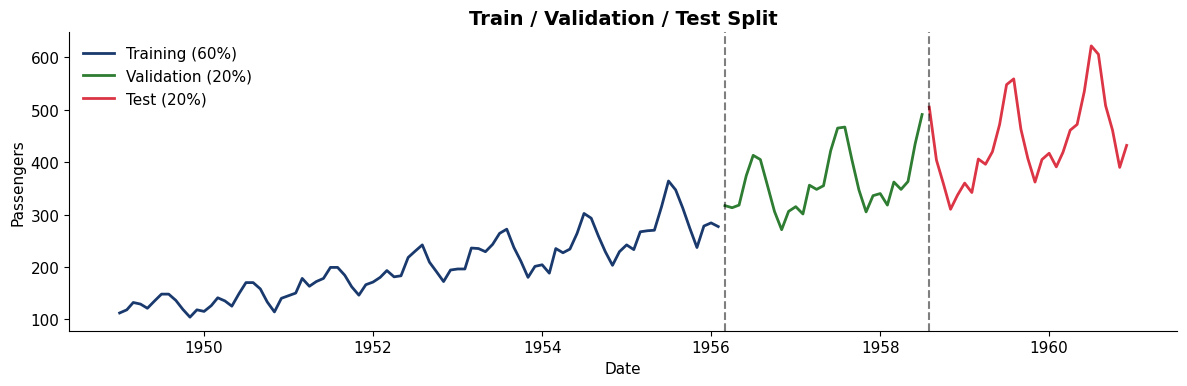

In [19]:
# Visualize train/validation/test split
n = len(airline)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(airline.index[:train_end], airline['Passengers'][:train_end],
        color=COLORS['blue'], linewidth=2, label='Training (60%)')
ax.plot(airline.index[train_end:val_end], airline['Passengers'][train_end:val_end],
        color=COLORS['green'], linewidth=2, label='Validation (20%)')
ax.plot(airline.index[val_end:], airline['Passengers'][val_end:],
        color=COLORS['red'], linewidth=2, label='Test (20%)')

ax.axvline(x=airline.index[train_end], color='black', linestyle='--', alpha=0.5)
ax.axvline(x=airline.index[val_end], color='black', linestyle='--', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.set_title('Train / Validation / Test Split', fontweight='bold', fontsize=14)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Time Series Cross-Validation

**Why not standard k-fold CV?**
- Time series have temporal dependence
- Future data cannot predict the past
- Standard k-fold causes data leakage

**Rolling Origin CV:**
1. Train on $\{X_1, \ldots, X_t\}$
2. Forecast $\hat{X}_{t+h}$
3. Increment $t$, repeat

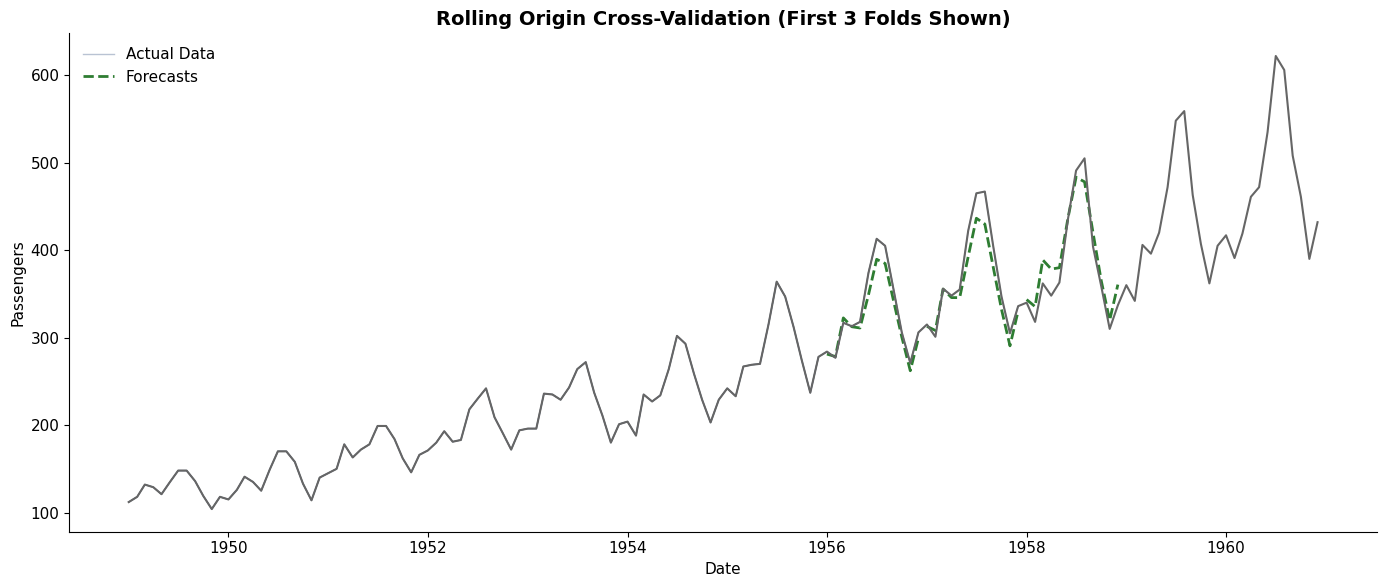


Cross-Validation Results:
Number of folds: 4
Mean RMSE: 18.08
Std RMSE: 3.38


In [20]:
# Demonstrate rolling origin cross-validation
data = airline['Passengers'].values
n = len(data)
initial_train_size = 84  # 7 years
horizon = 12  # 1 year ahead

errors = []
forecasts_cv = []
actuals_cv = []

fig, ax = plt.subplots(figsize=(14, 6))

# Show a few folds
for i, start in enumerate(range(initial_train_size, n - horizon, 12)):
    train = data[:start]
    test = data[start:start + horizon]

    # Fit Holt-Winters
    model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit()
    forecast = model.forecast(horizon)

    # Store results
    error = np.sqrt(mean_squared_error(test, forecast))
    errors.append(error)

    if i < 3:  # Show first 3 folds
        ax.plot(airline.index[:start], data[:start], color=COLORS['blue'],
                alpha=0.3, linewidth=1)
        ax.plot(airline.index[start:start+horizon], forecast,
                color=COLORS['green'], linewidth=2, linestyle='--')

ax.plot(airline.index, data, color=COLORS['gray'], linewidth=1.5, label='Actual')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.set_title('Rolling Origin Cross-Validation (First 3 Folds Shown)', fontweight='bold', fontsize=14)
ax.legend(['Actual Data', 'Forecasts'])
plt.tight_layout()
plt.show()

print(f"\nCross-Validation Results:")
print(f"Number of folds: {len(errors)}")
print(f"Mean RMSE: {np.mean(errors):.2f}")
print(f"Std RMSE: {np.std(errors):.2f}")

## 6. Modeling Seasonality

### Two Approaches

**1. Dummy Variables:**
$$X_t = \mu + \sum_{j=1}^{s-1}\gamma_j D_{jt} + \varepsilon_t$$
- $s-1$ parameters
- Any seasonal pattern

**2. Fourier Terms:**
$$X_t = \mu + \sum_{k=1}^{K}[\alpha_k\sin(2\pi kt/s) + \beta_k\cos(2\pi kt/s)] + \varepsilon_t$$
- $2K$ parameters
- Smooth patterns

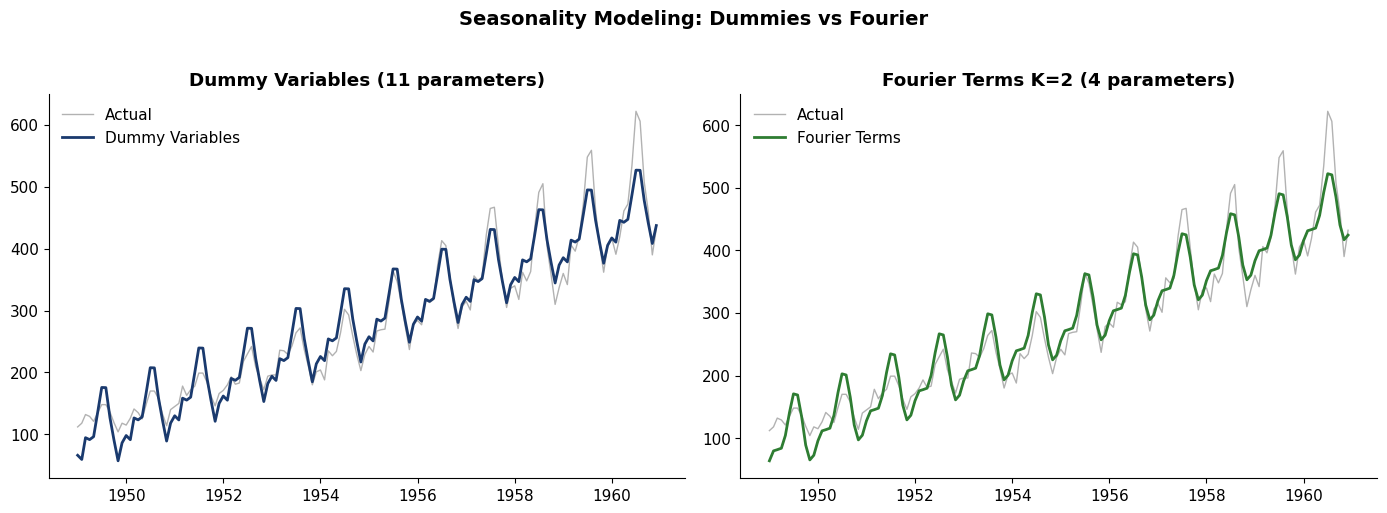

Dummy Variables RMSE: 25.11
Fourier Terms RMSE: 26.87


In [21]:
# Compare dummy variables vs Fourier terms
from sklearn.linear_model import LinearRegression

# Create dummy variables for months
airline_df = airline.copy()
airline_df['month'] = airline_df.index.month
airline_df['t'] = np.arange(len(airline_df))

# Create month dummies (drop January as reference)
dummies = pd.get_dummies(airline_df['month'], prefix='month', drop_first=True)
X_dummy = pd.concat([airline_df[['t']], dummies], axis=1)

# Create Fourier terms (K=2)
K = 2
fourier_terms = pd.DataFrame()
fourier_terms['t'] = airline_df['t']
for k in range(1, K + 1):
    fourier_terms[f'sin_{k}'] = np.sin(2 * np.pi * k * airline_df['t'] / 12)
    fourier_terms[f'cos_{k}'] = np.cos(2 * np.pi * k * airline_df['t'] / 12)

# Fit models
y = airline_df['Passengers']

model_dummy = LinearRegression().fit(X_dummy, y)
pred_dummy = model_dummy.predict(X_dummy)

model_fourier = LinearRegression().fit(fourier_terms, y)
pred_fourier = model_fourier.predict(fourier_terms)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(airline.index, y, color=COLORS['gray'], alpha=0.5, linewidth=1, label='Actual')
axes[0].plot(airline.index, pred_dummy, color=COLORS['blue'], linewidth=2, label='Dummy Variables')
axes[0].set_title(f'Dummy Variables (11 parameters)', fontweight='bold')
axes[0].legend(loc='upper left')

axes[1].plot(airline.index, y, color=COLORS['gray'], alpha=0.5, linewidth=1, label='Actual')
axes[1].plot(airline.index, pred_fourier, color=COLORS['green'], linewidth=2, label='Fourier Terms')
axes[1].set_title(f'Fourier Terms K={K} ({2*K} parameters)', fontweight='bold')
axes[1].legend(loc='upper left')

plt.suptitle('Seasonality Modeling: Dummies vs Fourier', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"Dummy Variables RMSE: {np.sqrt(mean_squared_error(y, pred_dummy)):.2f}")
print(f"Fourier Terms RMSE: {np.sqrt(mean_squared_error(y, pred_fourier)):.2f}")

## 7. Handling Trend and Seasonality

### Detrending Methods

1. **Differencing**: $\Delta X_t = X_t - X_{t-1}$
2. **Linear regression**: $\hat{T}_t = \hat{\beta}_0 + \hat{\beta}_1 t$
3. **HP Filter**: Balance fit vs smoothness
4. **Moving average**: $\hat{T}_t = MA_q(X_t)$

### Seasonal Adjustment

1. **Seasonal differencing**: $\Delta_s X_t = X_t - X_{t-s}$
2. **Division** (multiplicative): $X_t^{adj} = X_t / \hat{S}_t$
3. **Subtraction** (additive): $X_t^{adj} = X_t - \hat{S}_t$

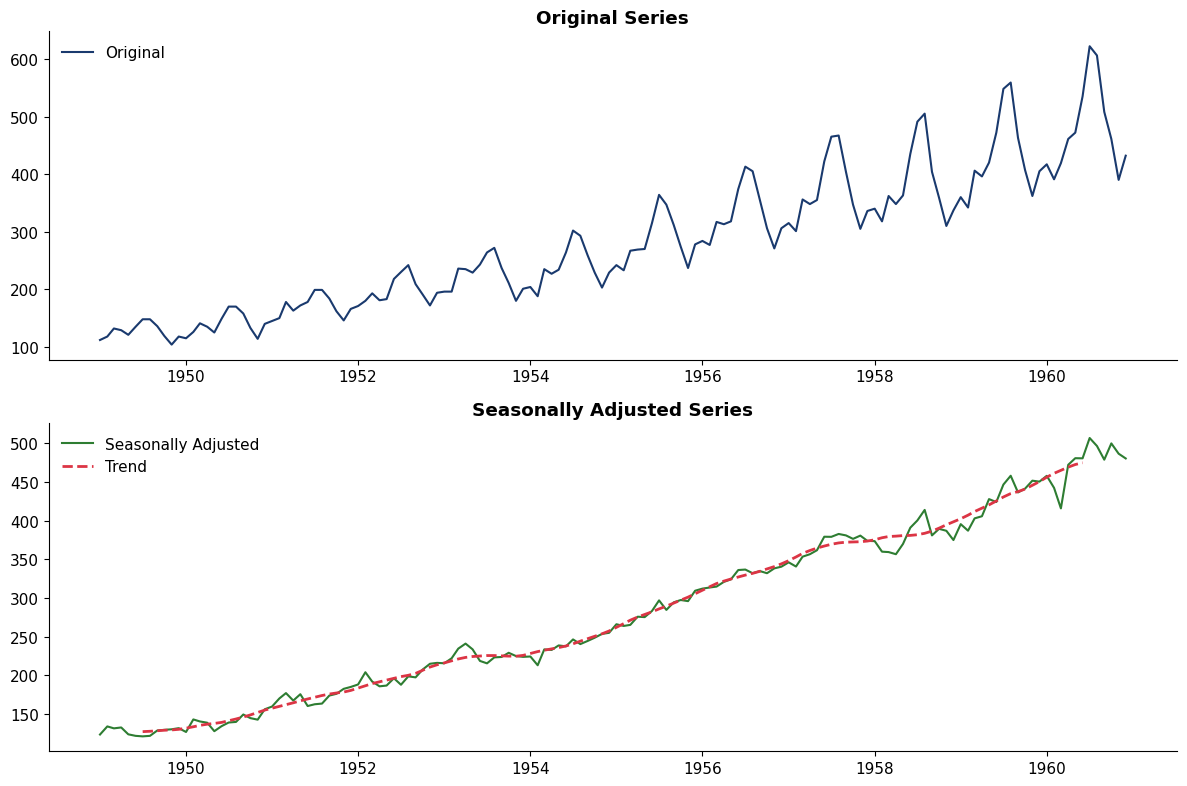

Seasonal adjustment removes periodic fluctuations, revealing the underlying trend.


In [22]:
# Seasonal adjustment
# Divide by seasonal factors (multiplicative)
seasonal_adj = airline['Passengers'] / decomposition.seasonal

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(airline.index, airline['Passengers'], color=COLORS['blue'], linewidth=1.5, label='Original')
axes[0].set_title('Original Series', fontweight='bold')
axes[0].legend(loc='upper left')

axes[1].plot(airline.index, seasonal_adj, color=COLORS['green'], linewidth=1.5, label='Seasonally Adjusted')
axes[1].plot(airline.index, decomposition.trend, color=COLORS['red'], linewidth=2,
             linestyle='--', label='Trend')
axes[1].set_title('Seasonally Adjusted Series', fontweight='bold')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

print("Seasonal adjustment removes periodic fluctuations, revealing the underlying trend.")

### Deterministic vs Stochastic Trend

**Deterministic Trend:**
$$X_t = \beta_0 + \beta_1 t + \varepsilon_t$$
- Trend is a function of time
- Detrend by **regression**

**Stochastic Trend:**
$$X_t = X_{t-1} + \varepsilon_t$$
- Random walk component
- Detrend by **differencing**

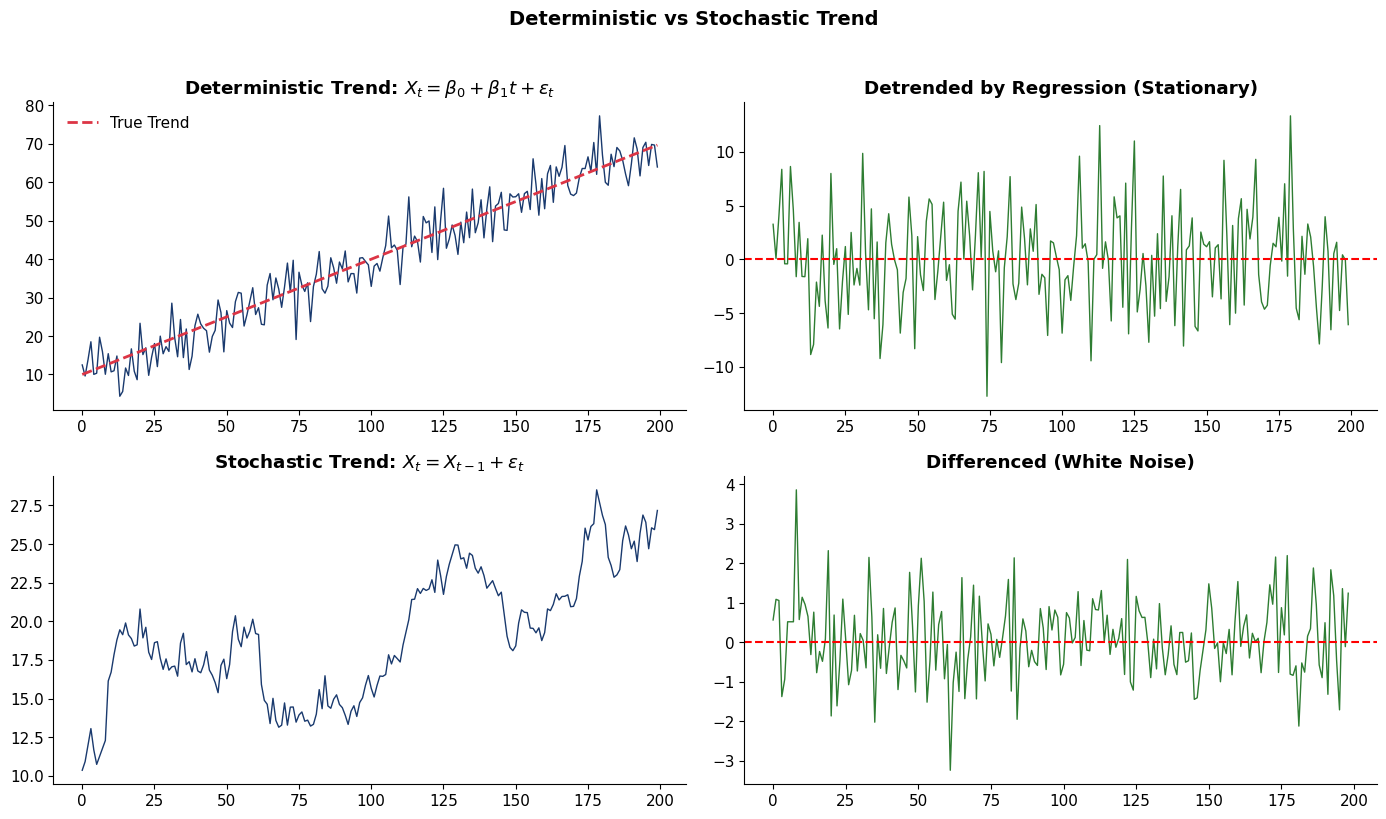

Key Insight:
- Deterministic trend -> Use REGRESSION to detrend
- Stochastic trend -> Use DIFFERENCING to detrend


In [23]:
# Simulate deterministic and stochastic trends
np.random.seed(42)
n = 200
t = np.arange(n)

# Deterministic trend: linear + noise
det_trend = 10 + 0.3 * t + np.random.randn(n) * 5

# Stochastic trend: random walk
stoch_trend = np.cumsum(np.random.randn(n)) + 10

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Deterministic trend
axes[0, 0].plot(det_trend, color=COLORS['blue'], linewidth=1)
axes[0, 0].plot(10 + 0.3 * t, color=COLORS['red'], linewidth=2, linestyle='--', label='True Trend')
axes[0, 0].set_title('Deterministic Trend: $X_t = \\beta_0 + \\beta_1 t + \\varepsilon_t$', fontweight='bold')
axes[0, 0].legend(loc='upper left')

# Detrended by regression
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(t.reshape(-1, 1), det_trend)
det_detrended = det_trend - model.predict(t.reshape(-1, 1))
axes[0, 1].plot(det_detrended, color=COLORS['green'], linewidth=1)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_title('Detrended by Regression (Stationary)', fontweight='bold')

# Stochastic trend
axes[1, 0].plot(stoch_trend, color=COLORS['blue'], linewidth=1)
axes[1, 0].set_title('Stochastic Trend: $X_t = X_{t-1} + \\varepsilon_t$', fontweight='bold')

# Detrended by differencing
stoch_diff = np.diff(stoch_trend)
axes[1, 1].plot(stoch_diff, color=COLORS['green'], linewidth=1)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_title('Differenced (White Noise)', fontweight='bold')

plt.suptitle('Deterministic vs Stochastic Trend', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Key Insight:")
print("- Deterministic trend -> Use REGRESSION to detrend")
print("- Stochastic trend -> Use DIFFERENCING to detrend")

## Summary

### Key Takeaways

1. **Time series** = observations indexed by time with temporal dependence
2. **Decomposition**: Additive ($X_t = T_t + S_t + \varepsilon_t$) vs Multiplicative ($X_t = T_t \times S_t \times \varepsilon_t$)
3. **Exponential Smoothing**: SES (level), Holt (trend), Holt-Winters (seasonal)
4. **Forecast Evaluation**: MAE, RMSE, MAPE; proper train/validation/test splits
5. **Seasonality Modeling**: Dummy variables (any pattern) or Fourier terms (smooth)
6. **Trend Handling**: Differencing (stochastic) or regression (deterministic)

### Important Formulas

| Method | Formula |
|--------|--------|
| SES | $\hat{X}_{t+1|t} = \alpha X_t + (1-\alpha)\hat{X}_{t|t-1}$ |
| Moving Average | $\hat{T}_t = \frac{1}{2q+1}\sum_{j=-q}^{q} X_{t+j}$ |
| First Difference | $\Delta X_t = X_t - X_{t-1}$ |
| Seasonal Difference | $\Delta_s X_t = X_t - X_{t-s}$ |

### Next Chapter: Stochastic Processes and Stationarity

- Stochastic processes definition
- Strict vs weak stationarity
- White noise and random walk
- ACF and PACF
- Unit root tests (ADF, KPSS)